In [1]:
import itertools
import pandas as pd
import numpy as np
import re
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Deep learning:
# from tensorflow.python.keras.models import Input

from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from keras.models import Model

# from keras.models import Input, Model

from scipy import sparse

texts = pd.read_csv('/content/drive/MyDrive/text-data/TextNLP.csv')

texts = [x for x in texts['text']]
print(len(texts))
print(texts)

12
['The future king is the prince', 'Daughter is the princess ', 'Son is the prince', 'Only a man can be a king ', 'Only a woman can be a queen', 'The princess will be a queen', 'Queen and king rule the realm', 'The prince is a strong man', 'The princess is a beautiful woman ', 'The royal family is the king and queen and their children', 'Prince is only a boy now', 'A boy will be a man']


In [2]:

def text_preprocessing(
        text: list,
        punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
        stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will', 'was', 'but', 'this', 'were', 'with', 'of', 'also',
                    'on', '.', 'for', 'any', 'its', 'and', 'are', 'from', 'both', 'as']
) -> list:
    """
    A method to preproces text
    """
    for x in text.lower():
        if x in punctuations:
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x != '']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

In [3]:
#Build list of word pairs**********************************************************************************************************
"""
[ ['future', 'king'],

['future', 'prince'],

['king', 'prince'],

['king', 'future'],

['prince', 'king'],

…..

]
"""
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []
for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)
    # print (text)

    # Appending to the all text list
    all_text += text

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text):
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

word_lists

[['future', 'king'],
 ['future', 'prince'],
 ['king', 'prince'],
 ['king', 'future'],
 ['prince', 'king'],
 ['prince', 'future'],
 ['daughter', 'princess'],
 ['princess', 'daughter'],
 ['son', 'prince'],
 ['prince', 'son'],
 ['only', 'man'],
 ['only', 'can'],
 ['man', 'can'],
 ['man', 'only'],
 ['man', 'king'],
 ['can', 'king'],
 ['can', 'man'],
 ['can', 'only'],
 ['king', 'can'],
 ['king', 'man'],
 ['only', 'woman'],
 ['only', 'can'],
 ['woman', 'can'],
 ['woman', 'only'],
 ['woman', 'queen'],
 ['can', 'queen'],
 ['can', 'woman'],
 ['can', 'only'],
 ['queen', 'can'],
 ['queen', 'woman'],
 ['princess', 'queen'],
 ['queen', 'princess'],
 ['queen', 'king'],
 ['queen', 'rule'],
 ['king', 'rule'],
 ['king', 'queen'],
 ['king', 'realm'],
 ['rule', 'realm'],
 ['rule', 'king'],
 ['rule', 'queen'],
 ['realm', 'rule'],
 ['realm', 'king'],
 ['prince', 'strong'],
 ['prince', 'man'],
 ['strong', 'man'],
 ['strong', 'prince'],
 ['man', 'strong'],
 ['man', 'prince'],
 ['princess', 'beautiful'],
 ['p

In [4]:
#Create Dictionry******************************************************************************************************************
"""
{'beautiful': 0, 'boy': 1, 'can': 2, 'children': 3, 'daughter': 4, 'family': 5,
'future': 6, 'king': 7, 'man': 8, 'now': 9, ……..}
"""
def create_unique_word_dict(text: list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict


unique_word_dict = create_unique_word_dict(all_text)
# Defining the number of features (unique words)
n_words = len(unique_word_dict)
print(unique_word_dict)

# Getting all the unique words
words = list(unique_word_dict.keys())
print(words)

{'beautiful': 0, 'boy': 1, 'can': 2, 'children': 3, 'daughter': 4, 'family': 5, 'future': 6, 'king': 7, 'man': 8, 'now': 9, 'only': 10, 'prince': 11, 'princess': 12, 'queen': 13, 'realm': 14, 'royal': 15, 'rule': 16, 'son': 17, 'strong': 18, 'their': 19, 'woman': 20}
['beautiful', 'boy', 'can', 'children', 'daughter', 'family', 'future', 'king', 'man', 'now', 'only', 'prince', 'princess', 'queen', 'realm', 'royal', 'rule', 'son', 'strong', 'their', 'woman']


In [5]:
#Convert the Data to one-hot*******************************************************************************************************


# Creating the X and Y matrices using one hot encoding
print(n_words)
X = []
Y = []
for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    print(word_list)
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])
    # print (word_list)
    print(word_list[0], main_word_index)
    print(word_list[1], context_word_index)

    # Creating the placeholders
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
print(X)
print(Y)

21


84it [00:00, 743.63it/s]

['future', 'king']
future 6
king 7
['future', 'prince']
future 6
prince 11
['king', 'prince']
king 7
prince 11
['king', 'future']
king 7
future 6
['prince', 'king']
prince 11
king 7
['prince', 'future']
prince 11
future 6
['daughter', 'princess']
daughter 4
princess 12
['princess', 'daughter']
princess 12
daughter 4
['son', 'prince']
son 17
prince 11
['prince', 'son']
prince 11
son 17
['only', 'man']
only 10
man 8
['only', 'can']
only 10
can 2
['man', 'can']
man 8
can 2
['man', 'only']
man 8
only 10
['man', 'king']
man 8
king 7
['can', 'king']
can 2
king 7
['can', 'man']
can 2
man 8
['can', 'only']
can 2
only 10
['king', 'can']
king 7
can 2
['king', 'man']
king 7
man 8
['only', 'woman']
only 10
woman 20
['only', 'can']
only 10
can 2
['woman', 'can']
woman 20
can 2
['woman', 'only']
woman 20
only 10
['woman', 'queen']
woman 20
queen 13
['can', 'queen']
can 2
queen 13
['can', 'woman']
can 2
woman 20
['can', 'only']
can 2
only 10
['queen', 'can']
queen 13
can 2
['queen', 'woman']
queen 13

In [6]:
#Convert Data to Tensors***********************************************************************************************************
import tensorflow as tf

# X= sparse.csr_matrix(X)
# Y = sparse.csr_matrix(Y)
# print (X)
# print(X[0, :].toarray())
# print (X.todense())
# a = X.todense()
# print (a[0])
XX = tf.convert_to_tensor(X, dtype=tf.float32)
YY = tf.convert_to_tensor(Y, dtype=tf.float32)
print(XX.shape)
print(YY.shape)


(84, 21)
(84, 21)


In [7]:
def CreateModel():
    # Defining the size of the embedding
    embed_size = 2
    # Defining the neural network

    # inp = Input(shape=(X.shape[1],))
    inp = Input(shape=XX.shape[1])  # 21
    x = Dense(units=embed_size, activation='linear')(inp)
    # x = Dense(units=21, activation='softmax')(x)
    x = Dense(units=YY.shape[1], activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    return model


model = CreateModel()
# Optimizing the network weights
model.fit(
    x=XX,
    y=YY,
    batch_size=10,
    epochs=2000
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 2)                 44        
                                                                 
 dense_1 (Dense)             (None, 21)                63        
                                                                 
Total params: 107 (428.00 Byte)
Trainable params: 107 (428.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2000
9/9 [==============================] - 1s 5ms/step - loss: 3.0473
Epoch 2/2000
9/9 [==============================] - 0s 6ms/step - loss: 3.0424
Epoch 3/2000
9/9 [==============================] - 0s 4ms/step - loss: 3.0387
Epoch 4/2000
9/9 [==============================] 

In [8]:
# The input layer

weights = model.get_weights()[0] #21*2
print(weights.shape)
print(weights[1][1])
print(weights)

(21, 2)
-1.3191149
[[-4.612409   -1.4640982 ]
 [ 4.042153   -1.3191149 ]
 [ 0.5010356   0.2648338 ]
 [-1.3950812   0.3505095 ]
 [-4.724941   -5.2935934 ]
 [-0.06992889  0.6628223 ]
 [ 1.8746334  -6.727941  ]
 [ 0.24337062  0.6951325 ]
 [ 1.9383314   0.22266272]
 [ 4.9003086   0.1966579 ]
 [ 0.97357184  0.07166337]
 [ 2.0744243   0.9083141 ]
 [-3.7916462   1.2217795 ]
 [-0.9750055  -1.8339689 ]
 [-0.32448003 -4.7901793 ]
 [-0.30825675 -2.5700665 ]
 [-0.02252915  0.9018863 ]
 [ 5.729457   -5.5415306 ]
 [ 4.2476616  -2.027958  ]
 [-0.7915983  -1.0700171 ]
 [-0.27615404  0.27603987]]


In [9]:
# weights = model.get_weights()[2]
# print (weights)

#get the weight for each unique word
embedding_dict = {}
for word in words: #to pick the a row of weight of two values for each unique word since weights = 21*2
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
    })

print(embedding_dict)

{'beautiful': array([-4.612409 , -1.4640982], dtype=float32), 'boy': array([ 4.042153 , -1.3191149], dtype=float32), 'can': array([0.5010356, 0.2648338], dtype=float32), 'children': array([-1.3950812,  0.3505095], dtype=float32), 'daughter': array([-4.724941 , -5.2935934], dtype=float32), 'family': array([-0.06992889,  0.6628223 ], dtype=float32), 'future': array([ 1.8746334, -6.727941 ], dtype=float32), 'king': array([0.24337062, 0.6951325 ], dtype=float32), 'man': array([1.9383314 , 0.22266272], dtype=float32), 'now': array([4.9003086, 0.1966579], dtype=float32), 'only': array([0.97357184, 0.07166337], dtype=float32), 'prince': array([2.0744243, 0.9083141], dtype=float32), 'princess': array([-3.7916462,  1.2217795], dtype=float32), 'queen': array([-0.9750055, -1.8339689], dtype=float32), 'realm': array([-0.32448003, -4.7901793 ], dtype=float32), 'royal': array([-0.30825675, -2.5700665 ], dtype=float32), 'rule': array([-0.02252915,  0.9018863 ], dtype=float32), 'son': array([ 5.729457

0  >>  beautiful
1  >>  boy
2  >>  can
3  >>  children
4  >>  daughter
5  >>  family
6  >>  future
7  >>  king
8  >>  man
9  >>  now
10  >>  only
11  >>  prince
12  >>  princess
13  >>  queen
14  >>  realm
15  >>  royal
16  >>  rule
17  >>  son
18  >>  strong
19  >>  their
20  >>  woman
0  >>  beautiful
1  >>  boy
2  >>  can
3  >>  children
4  >>  daughter
5  >>  family
6  >>  future
7  >>  king
8  >>  man
9  >>  now
10  >>  only
11  >>  prince
12  >>  princess
13  >>  queen
14  >>  realm
15  >>  royal
16  >>  rule
17  >>  son
18  >>  strong
19  >>  their
20  >>  woman


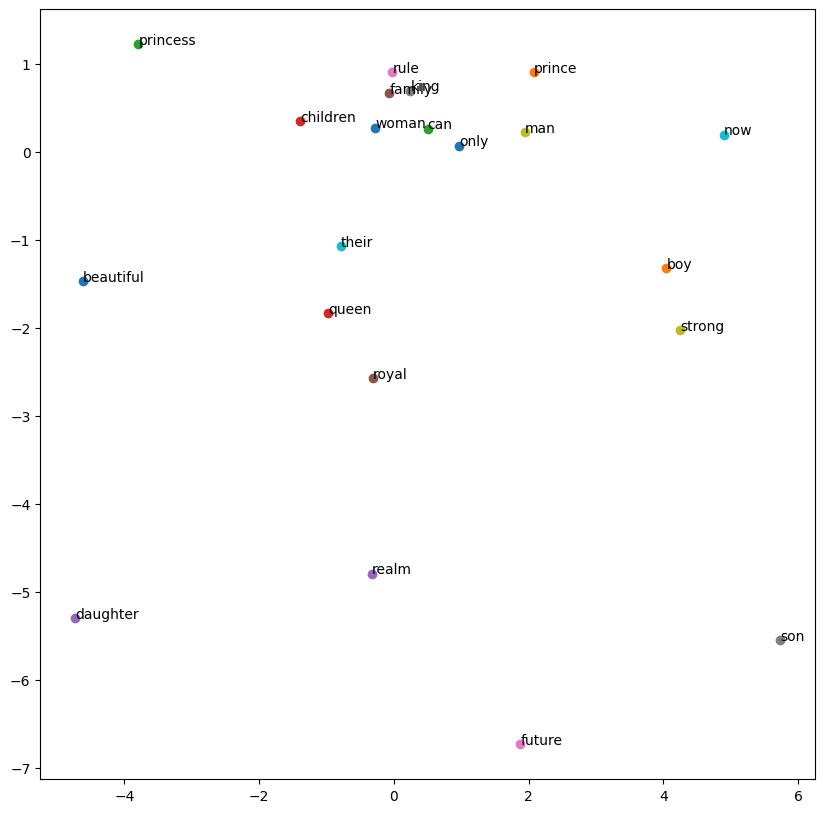

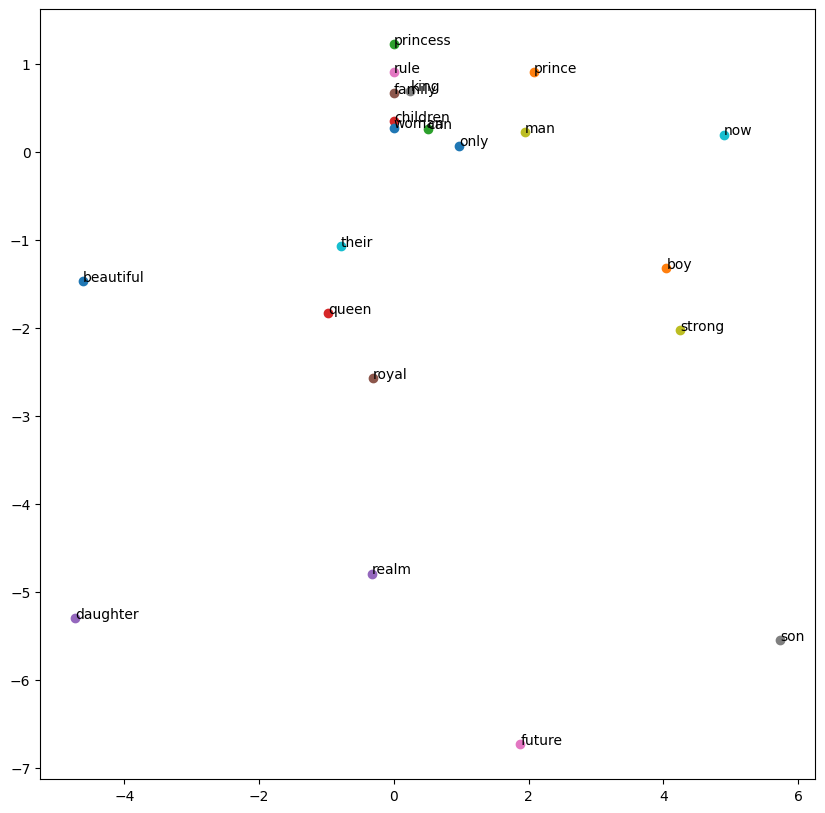

In [10]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict.keys()):
    print(i, ' >> ', word)
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))
    i = i + 1

# The input layer
weights = model.get_weights()[0]
# weights[: , 0] = 0
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
i = 0
for word in list(unique_word_dict.keys()):
    print(i, ' >> ', word)
    # coord = embedding_dict.get(word)
    coord = embedding_dict.get(word)
    if weights[i][0] < 0 and weights[i][1] > 0:
        plt.scatter(0, weights[i][1])
        plt.annotate(word, (0, weights[i][1]))
    else:
        plt.scatter(weights[i][0], weights[i][1])
        plt.annotate(word, (weights[i][0], weights[i][1]))

        #plt.xlim(-0.5, 0.5)
        #plt.ylim(-0.5, 0.5)
        #plt.show()
    i = i + 1

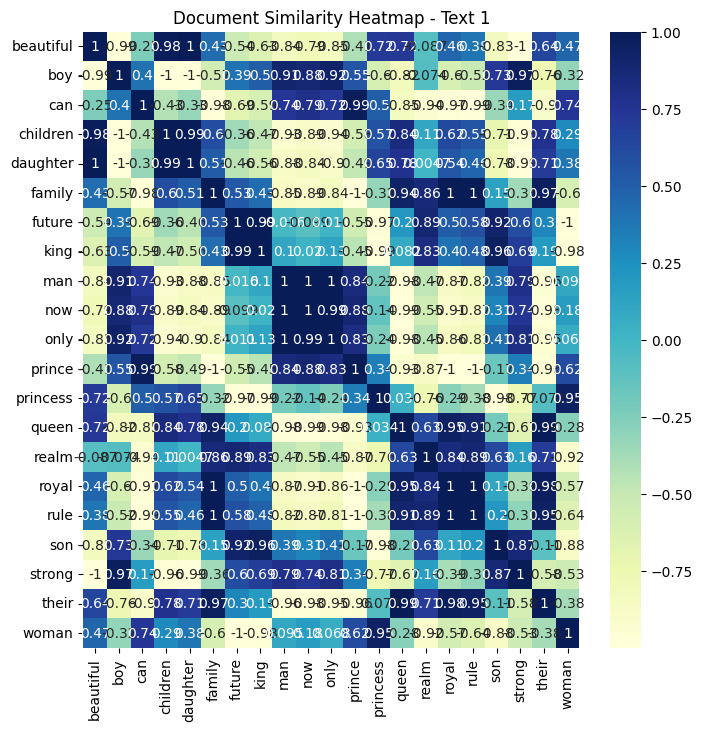

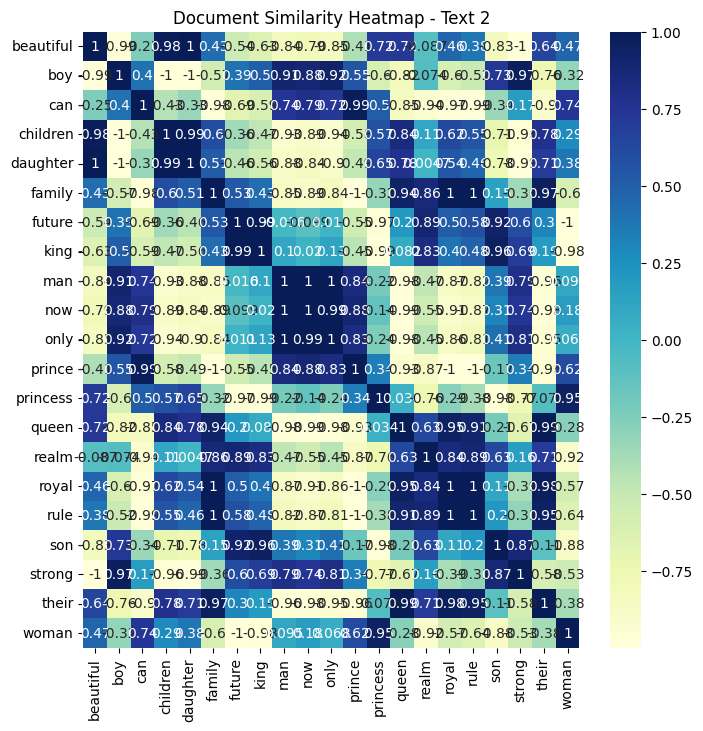

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


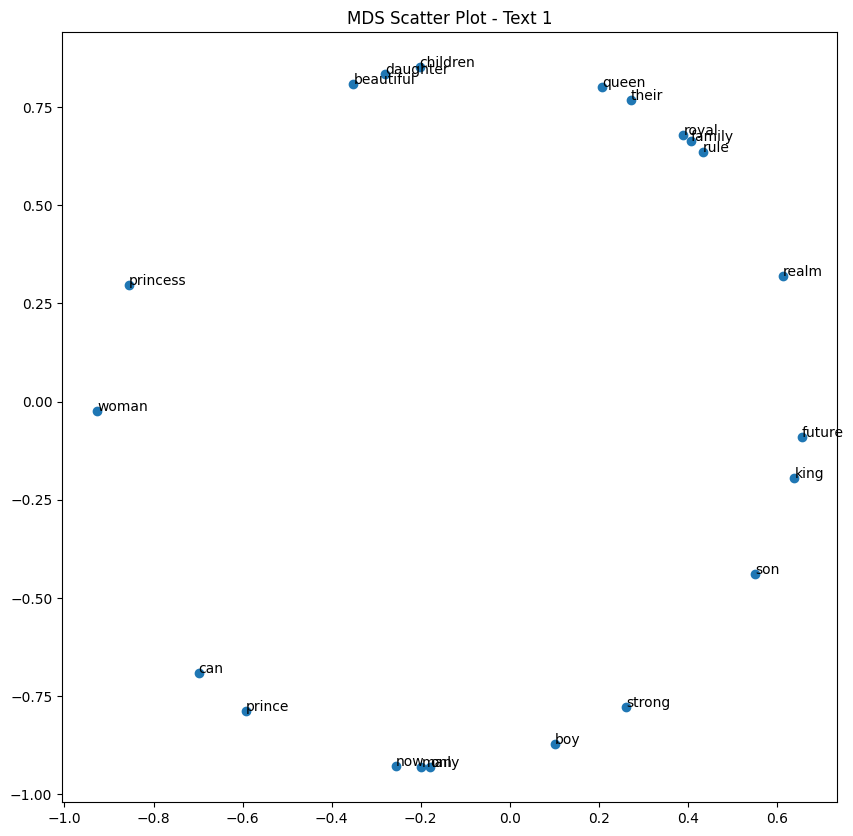

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


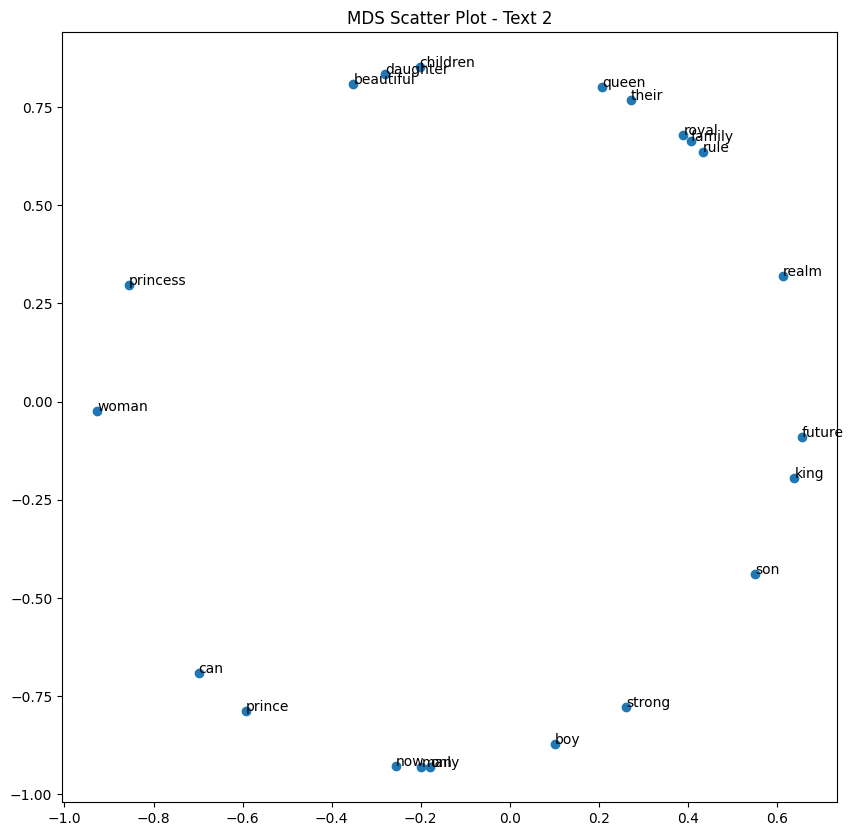

In [ ]:
# ... (existing code)

# ---- Additional Code for Similarity Calculation and Visualization ----

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
import seaborn as sns

# Function to calculate cosine similarity
def calculate_cosine_similarity(embedding_dict):
    embeddings = np.array(list(embedding_dict.values()))
    return cosine_similarity(embeddings)

# Calculate cosine similarity for text1 and text2
similarity_matrix_text1 = calculate_cosine_similarity(embedding_dict)
similarity_matrix_text2 = calculate_cosine_similarity(embedding_dict)

# ---- Heatmap Visualization ----

# Plot heatmap for text1
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix_text1, annot=True, cmap="YlGnBu", xticklabels=words, yticklabels=words)
plt.title("Document Similarity Heatmap - Text 1")
plt.show()

# Plot heatmap for text2
plt.figure(figsize=(8, 8))
sns.heatmap(similarity_matrix_text2, annot=True, cmap="YlGnBu", xticklabels=words, yticklabels=words)
plt.title("Document Similarity Heatmap - Text 2")
plt.show()

# ---- Multidimensional Scaling (MDS) ----

# Function to perform MDS and plot scatter plot
def plot_mds_scatter(embedding_dict, title):
    embeddings = np.array(list(embedding_dict.values()))
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    reduced_embeddings = mds.fit_transform(1 - calculate_cosine_similarity(embedding_dict))

    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
    plt.title(f"MDS Scatter Plot - {title}")
    plt.show()

# Plot MDS scatter plot for text1
plot_mds_scatter(embedding_dict, "Text 1")

# Plot MDS scatter plot for text2
plot_mds_scatter(embedding_dict, "Text 2")
